In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.preprocessing import StandardScaler

In [2]:
ID = ["ID"]
USER = ["SubjectID"]
TARGET = ["predefinedlabel"]
CONTROLS = ["VideoID", "SubjectID"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]

SEED = 5412
NUM_TRAIN_USERS = 7

In [3]:
# Read data
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + FEATURES + TARGET + CONTROLS]

data.head(3)

,ID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,VideoID,SubjectID
0,0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,0.0
1,0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,0.0
2,0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,0.0


In [4]:
data = data.groupby(ID).agg({
    "Delta": ["min", "mean", "max"],
    "Theta": ["min", "mean", "max"],
    "Alpha1": ["min", "mean", "max"],
    "Alpha2": ["min", "mean", "max"],
    "Beta1": ["min", "mean", "max"],
    "Beta2": ["min", "mean", "max"],
    "Gamma1": ["min", "mean", "max"],
    "Gamma2": ["min", "mean", "max"],
    "VideoID": "max",
    "SubjectID": "max",
    "predefinedlabel": "max",
})

FEATURES = list(map('_'.join, data.columns.values))[:-3]
data.columns = FEATURES + ["VideoID", "SubjectID", "predefinedlabel"]
data = data.reset_index(drop=True)

data.head(3)

,Delta_min,Delta_mean,Delta_max,Theta_min,Theta_mean,Theta_max,Alpha1_min,Alpha1_mean,Alpha1_max,Alpha2_min,...,Beta2_max,Gamma1_min,Gamma1_mean,Gamma1_max,Gamma2_min,Gamma2_mean,Gamma2_max,VideoID,SubjectID,predefinedlabel
0,2290.0,544315.097222,2723077.0,1945.0,124965.590278,1031826.0,374.0,36693.701389,556251.0,774.0,...,171258.0,1915.0,40729.284722,222111.0,1175.0,16817.062500,84108.0,0.0,0.0,0.0
1,15831.0,739737.292857,3224853.0,121.0,161064.228571,826317.0,25.0,34918.028571,304340.0,317.0,...,131248.0,214.0,36758.700000,141042.0,81.0,14519.407143,84001.0,1.0,0.0,0.0
2,17735.0,694078.084507,3958185.0,4262.0,149816.873239,961497.0,413.0,30493.873239,400302.0,648.0,...,145414.0,709.0,33908.873239,164217.0,524.0,14545.845070,66255.0,2.0,0.0,0.0


In [5]:
# Scaling the data

scaler = StandardScaler()
data[FEATURES] = scaler.fit_transform(data[FEATURES])

data.head(3)

,Delta_min,Delta_mean,Delta_max,Theta_min,Theta_mean,Theta_max,Alpha1_min,Alpha1_mean,Alpha1_max,Alpha2_min,...,Beta2_max,Gamma1_min,Gamma1_mean,Gamma1_max,Gamma2_min,Gamma2_mean,Gamma2_max,VideoID,SubjectID,predefinedlabel
0,-0.755334,-0.222369,0.050979,-0.738727,-0.489532,-0.322852,-0.504975,-0.198565,0.620472,-0.270442,...,-0.225722,0.262640,0.237249,0.047110,0.339196,0.121611,-0.128040,0.0,0.0,0.0
1,0.123315,0.466660,0.704472,-1.153845,-0.080951,-0.671206,-1.261775,-0.272472,-0.301121,-0.787455,...,-0.351759,-0.416819,0.154632,-0.192631,-0.502084,0.006241,-0.128553,1.0,0.0,0.0
2,0.246861,0.305673,1.659534,-0.211408,-0.208254,-0.442065,-0.420404,-0.456615,0.049947,-0.412988,...,-0.307134,-0.219093,0.095335,-0.124097,-0.161420,0.007569,-0.213555,2.0,0.0,0.0


In [6]:
data.groupby("VideoID", as_index=False).agg({"predefinedlabel": "max"})

,VideoID,predefinedlabel
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,4.0,0.0
5,5.0,1.0
6,6.0,1.0
7,7.0,1.0
8,8.0,1.0
9,9.0,1.0


In [7]:
from linearmodels import OLS

X = data[FEATURES + CONTROLS].copy()
y = data[TARGET].copy()

# user_dummies = pd.get_dummies(X["SubjectID"], drop_first=True, prefix="user_").astype("int")
# video_dummies = pd.get_dummies(X["VideoID"], drop_first=True, prefix="video_").astype("int")

X_with_dummies = pd.concat([X], axis=1)
X_with_dummies = X_with_dummies.drop(columns=CONTROLS)

mod = OLS(y, X_with_dummies)
res = mod.fit()

print(res.summary)

                            OLS Estimation Summary                            
Dep. Variable:        predefinedlabel   R-squared:                      0.1352
Estimator:                        OLS   Adj. R-squared:                -0.1379
No. Observations:                 100   F-statistic:                    25.972
Date:                Fri, Jul 25 2025   P-value (F-stat)                0.3546
Time:                        14:54:33   Distribution:                 chi2(24)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Delta_min       0.0926     0.1075     0.8615     0.3890     -0.1181      0.3034
Delta_mean      0.0511     0.2197     0.2325    

In [21]:
def ols_result_to_latex(res, save_path, caption="OLS Estimation Summary", label="tab:ols_summary"):
    df = res.params.to_frame("coef")
    df["std_err"] = res.std_errors
    df["t_stat"] = res.tstats
    df["p_value"] = res.pvalues
    conf_int = res.conf_int()
    df["ci_lower"] = conf_int.iloc[:, 0]
    df["ci_upper"] = conf_int.iloc[:, 1]

    # Round for LaTeX display
    df_rounded = df.round(4)

    # Start LaTeX table
    latex = []
    latex.append(r"\begin{table}[h]")
    latex.append(r"    \centering")
    latex.append(f"    \caption{{{caption}}}")
    latex.append(f"    \label{{{label}}}")
    latex.append(r"    \begin{tabular}{l S[table-format=1.4] S[table-format=1.4] S[table-format=1.4] S[table-format=1.4] S[table-format=1.4]}")
    latex.append(r"        \toprule")
    latex.append(r"        & \textbf{Parameter} & \textbf{Std. Err.} & \textbf{T-stat} & \textbf{P-value} & \textbf{Lower CI} & \textbf{Upper CI} \\")
    latex.append(r"        \midrule")

    for param, row in df_rounded.iterrows():
        latex.append(
            f"        {param} & {row['coef']} & {row['std_err']} & {row['t_stat']} & {row['p_value']} & {row['ci_lower']} & {row['ci_upper']} \\\\"
        )

    latex.append(r"        \bottomrule")
    latex.append(r"    \end{tabular}")
    latex.append(r"\end{table}")

    # Save
    with open(save_path, "w") as f:
        f.write("\n".join(latex))

ols_result_to_latex(
    res,
    save_path="../../assets/ols_estimation_summary.tex",
)

/tmp/ipykernel_1212/1780572297.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


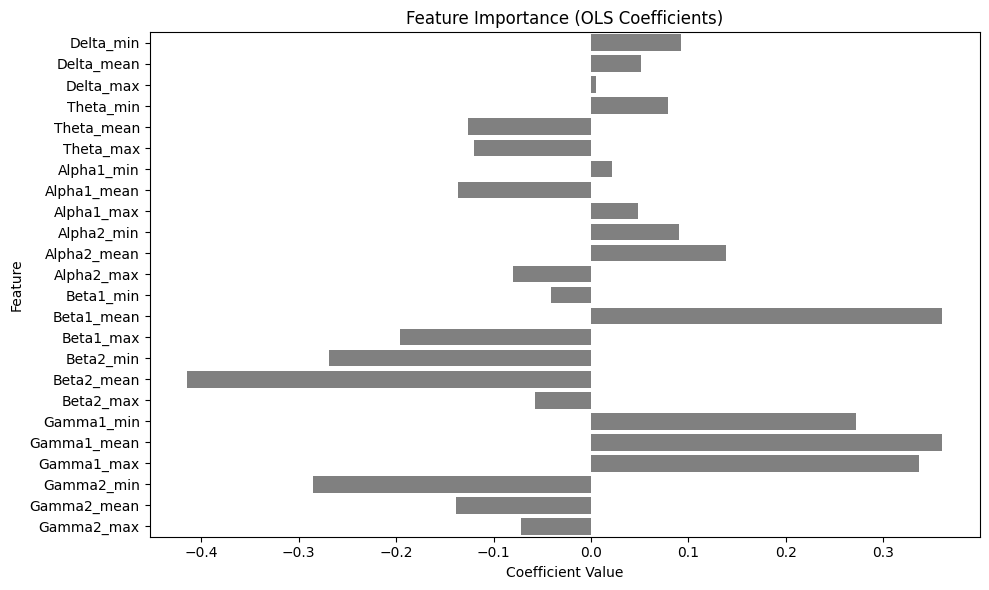

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

coefs = res.params
pvals = res.pvalues

feature_coefs = coefs[FEATURES]
feature_pvals = pvals[FEATURES]

coef_df = pd.DataFrame({
    'Feature': FEATURES,
    'Coefficient': feature_coefs.values,
    'P-value': feature_pvals.values
})

coef_df['Significant'] = coef_df['P-value'] < 0.05
colors = ['red' if sig else 'gray' for sig in coef_df['Significant']]

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df,
    palette=colors,
    orient='h'
)
plt.title("Feature Importance (OLS Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
